In [1]:
# importing modules required

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy as sc
import sklearn as sk
import statsmodels as st
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMAResults
from matplotlib import pyplot, legend, figure
from pandas import DataFrame
from scipy.stats import boxcox
from array import *

warnings.filterwarnings("ignore")

In [2]:
# read excel that is filtered to top 5 countries (ghg emissions)
df = pd.read_csv('germany_ghg_all_sector.csv')

In [3]:
# get top 5 rows "df"
df.head()

Country Data source                        Sector      Gas    Unit  Year  \
0  Germany        CAIT                        Energy  All GHG  MtCO₂e  2018   
1  Germany        CAIT          Industrial Processes  All GHG  MtCO₂e  2018   
2  Germany        CAIT                   Agriculture  All GHG  MtCO₂e  2018   
3  Germany        CAIT                         Waste  All GHG  MtCO₂e  2018   
4  Germany        CAIT  Land-Use Change and Forestry  All GHG  MtCO₂e  2018   

   Gas Emitted  
0       713.82  
1        25.34  
2        58.30  
3         8.63  
4       -29.48

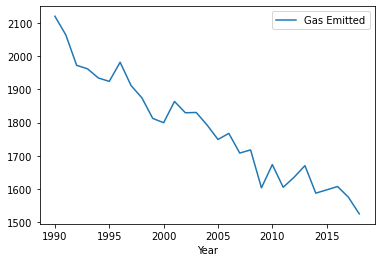

In [4]:
# plot time series of Year vs Gas Emitted - top5 countries (ghg)
top10_ghg_countries = df.groupby(['Year']).sum().plot()

In [5]:
# get top 5 rows of "top10_ghg_countries" after it have been summed, groupby year
top10_ghg_countries = df.groupby(['Year']).sum()
top10_ghg_countries.head()

Gas Emitted
Year             
1990      2119.58
1991      2063.71
1992      1972.01
1993      1961.47
1994      1933.88

In [6]:
# reset first column to be index from 0 onwards instead of year
reset_index = df.groupby(['Year']).sum().reset_index()
# show columns of reset_index
reset_index.columns

Index(['Year', 'Gas Emitted'], dtype='object')

In [7]:
# drop null values if there are

top10_ghg_countries.dropna(inplace=True)

# assigning training and testing dataset based on 50% split
x = top10_ghg_countries.values
train_size = int(len(top10_ghg_countries) * 0.80)
train, test = x[0:train_size], x[train_size:]

In [8]:
# ARIMA model 

# Dataset > period 1990 - 2003
# Validation set > period 2004 - 2018 

# assigning training and testing dataset based on 80% split
train_size = int(len(top10_ghg_countries) * 0.80)
split_point = len(top10_ghg_countries) - 12
dataset, validation = top10_ghg_countries[0:split_point], top10_ghg_countries[split_point:]

# number of years used in each set
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

# save each set into a csv file
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 17, Validation 12


In [9]:
# function arima

def evaluate_arima_model(X, arima_order):

    X = top10_ghg_countries.astype('float32')
    
    # assigning training and testing dataset based on 80% split
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # for every record from historical years, append into a list to be used for prediction
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        
        # expected trend to be non constant, hence trend = nc
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # To calculate RMSE to see how well the model fits
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

In [10]:
# search for optimal ARIMA parameters automatically
# if automatic method does not work, proceed to use manual method below

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA = %s \nRMSE = %.3f' % (best_cfg, best_score))
    
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(top10_ghg_countries.values, p_values, d_values, q_values)

Best ARIMA = None 
RMSE = inf


In [11]:
# Identify best ARIMA model manually

# check if stationary
result = adfuller(top10_ghg_countries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -1.363755
p-value: 0.599524
Critical Values:
	1%: -3.700
	5%: -2.976
	10%: -2.628


In [12]:
# By looking at the p-value of this test, we cannot reject the null hypothesis, 
# and it is likely that our dataset is non-stationary. We therefore choose the first parameter in 
# our ARIMA model (the p) as a 1. We do not choose a higher number because although our 
# dataset is non-stationary, it is not likely that seasonality is present because we work with annual data.

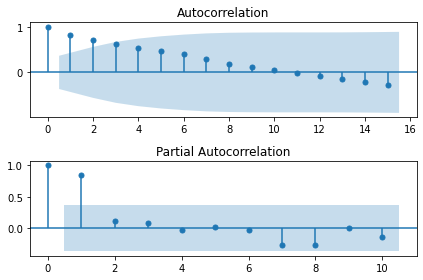

In [13]:
# Creates ACF and PACF plots
pyplot.figure()
pyplot.subplot(211)
plot_acf(top10_ghg_countries, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(top10_ghg_countries, ax=pyplot.gca(), lags = 10)
pyplot.tight_layout()
pyplot.show()

In [14]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # prediction
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    #observation
    obs = test[i]
    history.append(obs)

# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

               0
count   6.000000
mean  -19.808328
std    43.712528
min   -76.546685
25%   -50.327515
50%   -19.139064
75%     7.085048
max    40.872092


In [15]:
# saving the ARIMA model

def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__

model = ARIMA(x, order=(1,0,0))
model_fit = model.fit(trend='nc', disp=0)

# bias would be the "mean" that was shown in previous cell
bias = -19.808328

model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

In [16]:
# load model and predict one period in the future

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 1504.942


In [17]:
# validate using dataset and validation set

# function for difference of dataset
def difference(dataset):
        diff = list()
        for i in range(1, len(dataset)):
                value = dataset[i] - dataset[i - 1]
                diff.append(value)
        return diff

X = top10_ghg_countries.values
X = X.astype('float32')    

# difference data
stationary = difference(X)

# data frame of difference data
df_X = pd.DataFrame({'Year': top10_ghg_countries.index.values, 'X':X.flatten()})

In [18]:
# validation set

validation = pd.read_csv('validation.csv')

def difference(validation):
        diff = list()
        for i in range(1, len(validation)):
                value = validation[i] - validation[i - 1]
                diff.append(value)
        return diff

y = np.array(validation['Gas Emitted'])
y = y.astype('float32')
      
stationary = difference(y)

df_y = pd.DataFrame({'Year': validation.index.values,'y':y.flatten()})


In [19]:
# prediction vs actual for 1990
history = [x for x in X]

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')

predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted = %.3f, Expected = %3.f' % (yhat, y[0]))

>Predicted = 1504.942, Expected = 1708


>Predicted = 1687.607, Expected = 1718
>Predicted = 1697.044, Expected = 1604
>Predicted = 1583.089, Expected = 1674
>Predicted = 1652.872, Expected = 1605
>Predicted = 1584.746, Expected = 1636
>Predicted = 1614.832, Expected = 1670
>Predicted = 1649.805, Expected = 1588
>Predicted = 1567.067, Expected = 1598
>Predicted = 1576.948, Expected = 1608
>Predicted = 1587.099, Expected = 1576
>Predicted = 1554.979, Expected = 1525
RMSE: 78.42
MAE: 61.29


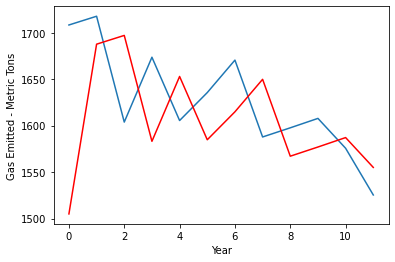

In [20]:
# plot graph based on predictions (red) vs actuals (blue) from year 1990 to 2004

for i in range(1, len(y)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)

    obs=y[i]
    history.append(obs)
    print('>Predicted = %.3f, Expected = %3.f' % (yhat, obs))
    
# mean squared error
mse = mean_squared_error(y, predictions)
# root mean squared error
rmse = sqrt(mse)
print('RMSE: %.2f' % rmse)
# mean absolute error
mae = mean_absolute_error(y, predictions)
print('MAE: %.2f' % mae)


pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.xlabel('Year')
pyplot.ylabel('Gas Emitted - Metric Tons')
pyplot.show()

In [21]:
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
forecast = model_fit.forecast(steps=12)[0]
print (forecast)

[1524.7502211  1524.16067024 1523.57134733 1522.98225229 1522.39338502
 1521.80474544 1521.21633346 1520.62814899 1520.04019195 1519.45246224
 1518.86495978 1518.27768448]


In [22]:
arr = (np.array([np.nan]))

In [23]:
# arr

In [24]:
for i in range(29):
    predictions.insert(0,arr)

In [25]:
# to identify prediction in 2030
year_2030 = predictions[40][0]
round(year_2030,2)

1554.98

Text(0, 0.5, 'Gas Emitted - Metric Ton')

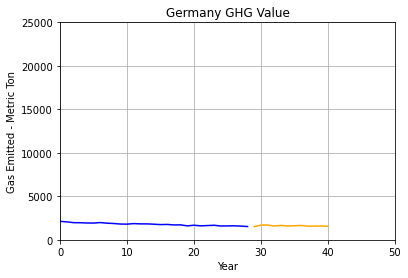

In [26]:
# prediction of GHG up to year 50. Year 0 is 1990, year 50 is 2040

plt.grid()
plt.plot(predictions, color = 'orange' )
plt.plot(x, color = 'b')
plt.xlim ((0,50))
plt.ylim ((0,25000))
plt.title('Germany GHG Value')
plt.xlabel('Year')
plt.ylabel('Gas Emitted - Metric Ton')

In [27]:
# for comparing purposes
for i in predictions:
    print (i[0])

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1504.9418930995548
1687.607492346373
1697.0443047123745
1583.089111990428
1652.8718883079152
1584.7464400897193
1614.8322725930957
1649.804668100122
1567.0668647368568
1576.948299284249
1587.0985974697765
1554.9785939021278
